# Compute behavioral similarity (via syllable usage) across individuals for different ages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from toolz import partial
from scipy.spatial.distance import cdist, pdist, squareform
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, LONGTOGENY_AGE_CMAP

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "beh-individualization", tight_layout=False)

In [3]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_raw_usage_matrix_v00.parquet')
df = df[keep_syllables]
df = df.query('age < 90')
index = ['age', 'mouse', 'uuid', 'subject_name', 'session_name', 'date']

In [ ]:
index = ['binned_age'] + index
ages = df.index.get_level_values('age')
df = df.reset_index()

In [12]:
weeks = (ages * 7) // 7

In [13]:
# n_bins = 67
# lbls, bins = pd.cut(ages, n_bins, labels=False, retbins=True)
# df['binned_age'] = lbls

df['binned_age'] = weeks
binned_ages = df.groupby(['binned_age', 'mouse'], observed=True).mean(numeric_only=True)

In [17]:
sample = df.groupby(['mouse', 'binned_age']).first()

In [21]:
def shuffle_mouse_age(df):
    '''df parameter corresponds to all mice at a certain age/age bin'''
    df = df.reset_index()
    df['binned_age'] = df.groupby('mouse')['binned_age'].sample(frac=1).to_numpy()
    return df.set_index(index)

In [22]:
shuff_dists = []
n_shuffs = 100
for i in range(n_shuffs):
    shuff_df = shuffle_mouse_age(df)
    dists = shuff_df.groupby('binned_age').apply(partial(pdist, metric='jensenshannon'))
    avg_dist = dists.apply(lambda x: x.mean())
    avg_dist.name = i
    shuff_dists.append(avg_dist)
shuff_dists = pd.DataFrame(shuff_dists)
shuff_dists.index.name = 'shuffle'

In [23]:
shuff_df = shuff_dists.reset_index().melt(id_vars='shuffle', value_name='dist')

<Axes: xlabel='binned_age', ylabel='dist'>

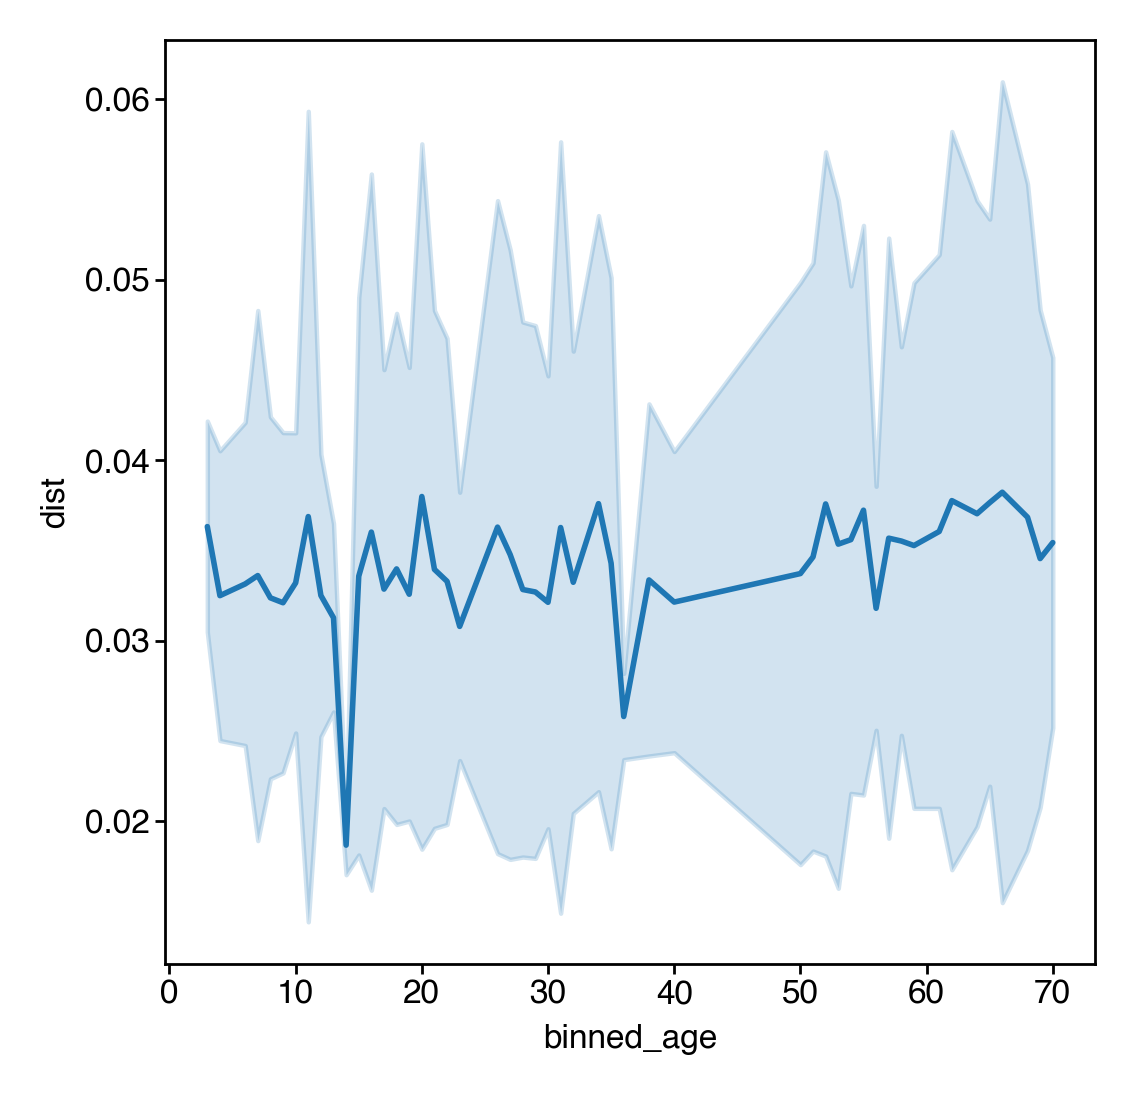

In [25]:
sns.lineplot(data=shuff_df, x='binned_age', y='dist', errorbar='sd')

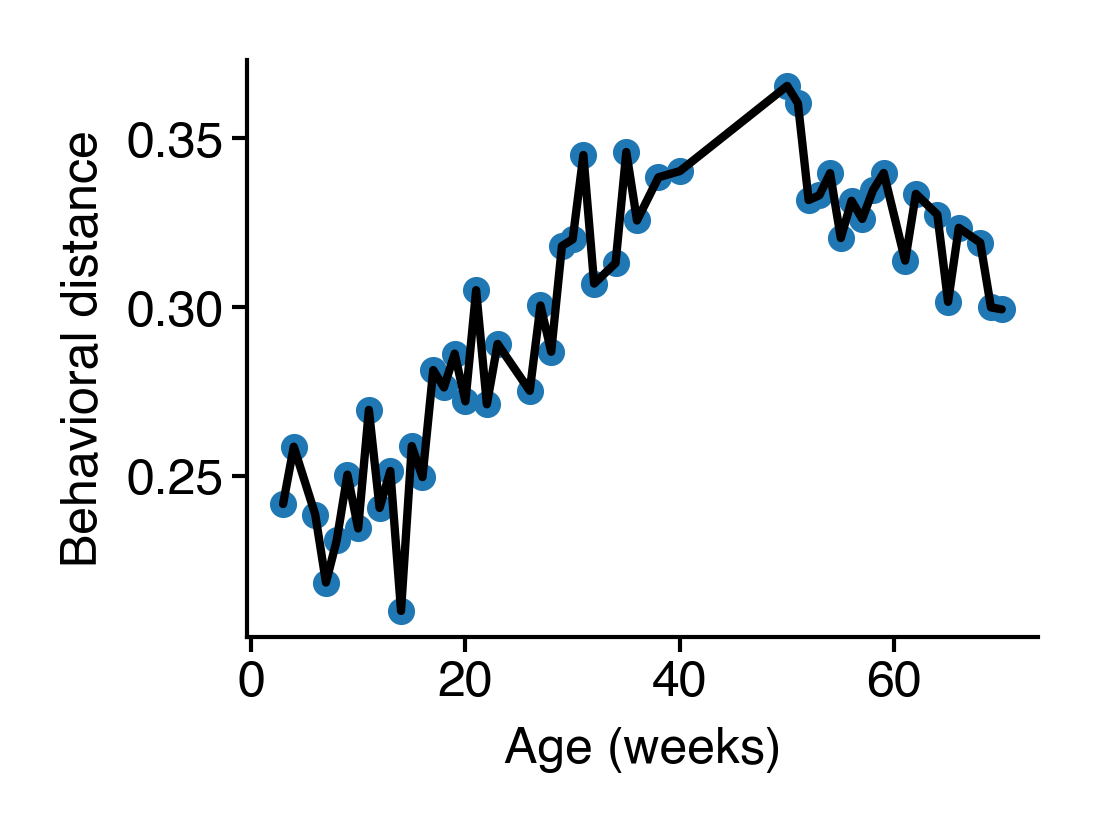

In [26]:
dists = df.set_index(index).groupby('binned_age').apply(partial(pdist, metric='jensenshannon'))
avg_dist = dists.apply(lambda x: x.mean())
avg_dist.name = 'dist'

fig = figure(1.7, 1.25)
ax = avg_dist.plot(c='k', lw=1)
ax = pd.DataFrame(avg_dist).reset_index().plot(kind='scatter', x='binned_age', y='dist', ax=ax, s=6)
ax.set(xlabel="Age (weeks)", ylabel="Behavioral distance")
sns.despine()
# saver(fig, 'jsd-

In [27]:
def shuffle_binned_mouse_age(df):
    '''df parameter corresponds to all mice at a certain age/age bin'''
    df = df.reset_index()
    df['binned_age'] = df.groupby('mouse')['binned_age'].sample(frac=1, replace=True).to_numpy()
    return df.set_index(['binned_age', 'mouse']) 

In [28]:
shuff_dists = []
n_shuffs = 1_000
for i in range(n_shuffs):
    shuff_df = shuffle_binned_mouse_age(binned_ages)
    dists = shuff_df.drop(columns=['age']).groupby('binned_age').apply(partial(pdist, metric='jensenshannon'))
    avg_dist = dists.apply(lambda x: x.mean()).reindex(range(n_bins))
    avg_dist.name = i
    avg_dist.index = pd.Index((bins[:-1] + bins[1:]) / 2, name='binned_age')
    shuff_dists.append(avg_dist)
shuff_dists = pd.DataFrame(shuff_dists)
shuff_dists.index.name = 'shuffle'
shuff_df = shuff_dists.reset_index().melt(id_vars='shuffle', value_name='dist')

/tmp/ipykernel_24744/4196221670.py:6: RuntimeWarning: Mean of empty slice.
  avg_dist = dists.apply(lambda x: x.mean()).reindex(range(n_bins))
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_24744/4196221670.py:6: RuntimeWarning: Mean of empty slice.
  avg_dist = dists.apply(lambda x: x.mean()).reindex(range(n_bins))
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_24744/4196221670.py:6: RuntimeWarning: Mean of empty slice.
  avg_dist = dists.apply(lambda x: x.mean()).reindex(range(n_bins))
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykerne

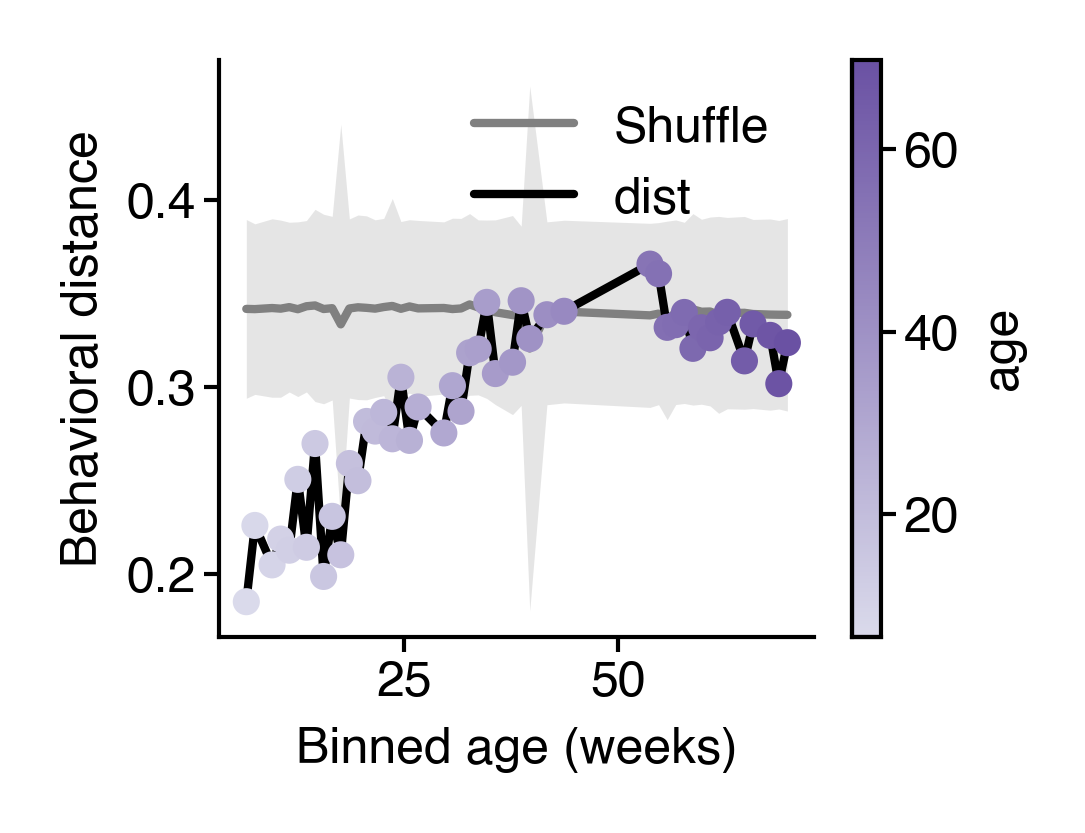

In [29]:
dists = binned_ages.drop(columns=['age']).groupby('binned_age').apply(partial(pdist, metric='jensenshannon'))
avg_dist = dists.apply(lambda x: x.mean()).reindex(range(n_bins))
avg_dist.name = 'dist'
avg_dist.index = pd.Index((bins[:-1] + bins[1:]) / 2, name='age')
avg_dist = avg_dist.dropna()

fig = figure(1.6, 1.25)
ax = fig.gca()
sns.lineplot(data=shuff_df, x='binned_age', y='dist', errorbar=('sd', 2), color='gray', err_kws=dict(lw=0), ax=ax, label='Shuffle', zorder=0)
ax = avg_dist.plot(c='k', lw=1, zorder=1, ax=ax)
ax = pd.DataFrame(avg_dist).reset_index().plot(kind='scatter', x='age', y='dist', c='age', s=6, cmap=LONGTOGENY_AGE_CMAP, ax=ax, zorder=2)
ax.set(xlabel="Binned age (weeks)", ylabel="Behavioral distance")
ax.legend(frameon=False)
# legend(ax)

sns.despine()
# saver(fig, "age-vs-behavioral-distance-binned");

## examples of syllable usage between two animals at young vs old age

In [14]:
ba = df.set_index(index).groupby(['binned_age', 'mouse']).mean()

In [15]:
ba

0         1         2         3         4         5   \
binned_age mouse                                                               
0          01_01  0.048707  0.089941  0.033939  0.030052  0.019839  0.029141   
           01_02  0.045601  0.056511  0.038452  0.018017  0.034224  0.041006   
           01_03  0.041422  0.051255  0.025223  0.018558  0.015373  0.030774   
           01_04  0.032180  0.056996  0.025981  0.008986  0.021327  0.033730   
           02_01  0.054697  0.117447  0.037123  0.031788  0.015433  0.019869   
...                    ...       ...       ...       ...       ...       ...   
15         03_04  0.107327  0.034064  0.041391  0.031255  0.030320  0.016987   
           04_01  0.046098  0.013561  0.012963  0.030285  0.025282  0.012475   
           04_02  0.084652  0.000534  0.027954  0.046259  0.047574  0.001850   
           04_03  0.057064  0.007681  0.020046  0.044539  0.038822  0.023801   
           04_04  0.050698  0.042645  0.031883  0.040793  0.029519  0.029805   

                        6         7         8         9   ...        44  \
binned_age mouse                                          ...             
0          01_01  0.016665  0.037127  0.026243  0.025699  ...  0.002606   
           01_02  0.015687  0.021518  0.017037  0.025704  ...  0.009114   
           01_03  0.017365  0.026414  0.025352  0.025875  ...  0.007839   
           01_04  0.015250  0.033606  0.020244  0.021545  ...  0.010784   
           02_01  0.011771  0.029545  0.022657  0.032827  ...  0.001095   
...                    ...       ...       ...       ...  ...       ...   
15         03_04  0.020804  0.032231  0.041457  0.017130  ...  0.003115   
           04_01  0.046147  0.025423  0.035589  0.009339  ...  0.007624   
           04_02  0.068940  0.001728  0.048399  0.000534  ...  0.002716   
           04_03  0.053729  0.013467  0.018576  0.007007  ...  0.007177   
           04_04  0.036378  0.031205  0.008897  0.026562  ...  0.004761   

                        45        47        54        55        57        58  \
binned_age mouse                                                               
0          01_01  0.000781  0.005457  0.001584  0.003837  0.010696  0.000209   
           01_02  0.002238  0.009349  0.004951  0.009327  0.006337  0.003653   
           01_03  0.003311  0.007876  0.009834  0.013375  0.014238  0.003341   
           01_04  0.002920  0.007298  0.004276  0.009731  0.011094  0.001495   
           02_01  0.000224  0.004624  0.000736  0.001045  0.002326  0.000067   
...                    ...       ...       ...       ...       ...       ...   
15         03_04  0.013693  0.011125  0.006234  0.001445  0.004532  0.006422   
           04_01  0.011694  0.005471  0.000802  0.002982  0.003916  0.001425   
           04_02  0.028263  0.008286  0.000162  0.000672  0.000180  0.000664   
           04_03  0.011435  0.006457  0.004473  0.001134  0.005759  0.004198   
           04_04  0.011330  0.006028  0.004385  0.009028  0.007813  0.004982   

                        60        63        73  
binned_age mouse                                
0          01_01  0.005708  0.003725  0.001589  
           01_02  0.006136  0.009140  0.004812  
           01_03  0.004667  0.011551  0.006148  
           01_04  0.006419  0.012024  0.005161  
           02_01  0.004416  0.002090  0.000842  
...                    ...       ...       ...  
15         03_04  0.003372  0.004038  0.007896  
           04_01  0.015192  0.001445  0.004344  
           04_02  0.032436  0.000534  0.006006  
           04_03  0.010185  0.001826  0.010825  
           04_04  0.007199  0.003120  0.008048  

[214 rows x 51 columns]

In [16]:
ba.index.levels[0]

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15], dtype='int64', name='binned_age')

In [17]:
ind1 = 1
ind2 = 13
b1 = ba.loc[ind1, "03_01"].to_numpy().squeeze()
b2 = ba.loc[ind1, "03_04"].to_numpy().squeeze()

b3 = ba.loc[ind2, "03_01"].to_numpy().squeeze()
b4 = ba.loc[ind2, "03_04"].to_numpy().squeeze()

syll_df = pd.concat(
    [
        pd.DataFrame(
            dict(
                diff=b1 - b2,
                sort_diff=np.sort(b1 - b2),
                m1=b1,
                m2=b2,
                age=int(avg_dist.index[ind1]),
                ord=np.arange(len(b1))[np.argsort(b1 - b2)],
            )
        ),
        pd.DataFrame(
            dict(
                diff=b3 - b4,
                sort_diff=np.sort(b3 - b4),
                m1=b3,
                m2=b4,
                age=int(avg_dist.index[ind2]),
                ord=np.arange(len(b3))[np.argsort(b3 - b4)],
            )
        ),
    ]
).reset_index()
syll_df = syll_df.rename(columns={"index": "syllable"})

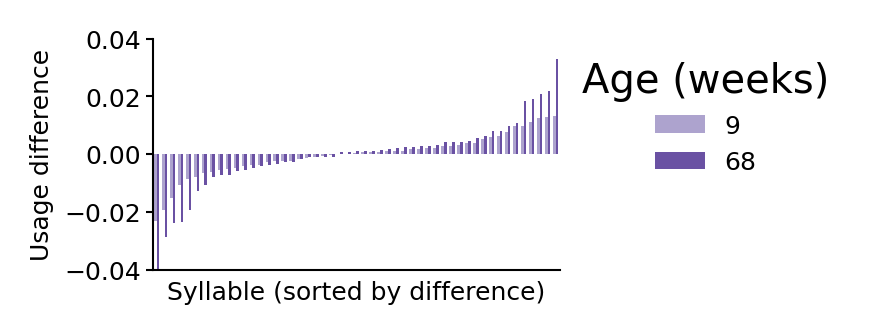

In [18]:
rs = LONGTOGENY_AGE_CMAP.resampled(6)
fig = figure(1.75, 1)
ax = sns.barplot(data=syll_df, x='syllable', y='sort_diff', hue='age', palette=rs([2, 5]).tolist(), width=0.7, saturation=1, lw=0)
ax.set(xticks=[], ylabel="Usage difference", ylim=[-0.04, 0.04], xlabel="Syllable (sorted by difference)")
sns.despine()
legend(ax, title="Age (weeks)")
saver(fig, "sorted-usage-difference-examples");

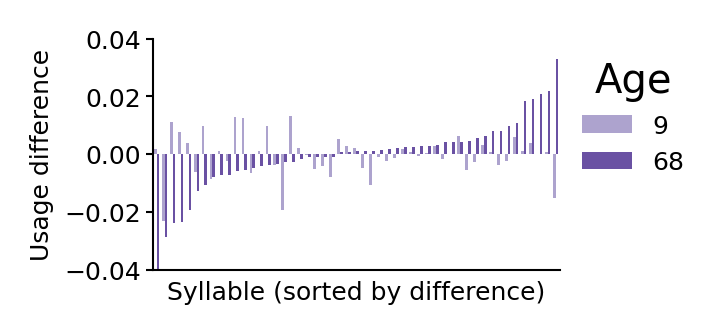

In [19]:
rs = LONGTOGENY_AGE_CMAP.resampled(6)
fig = figure(1.75, 1)
ord = syll_df.query('age == 68').sort_values(by='diff')['syllable']
ax = sns.barplot(data=syll_df, x='syllable', y='diff', hue='age', palette=rs([2, 5]).tolist(), width=0.7, saturation=1, order=ord, lw=0)
ax.set(xticks=[], ylabel="Usage difference", ylim=[-0.04, 0.04], xlabel="Syllable (sorted by difference)")
sns.despine()
legend(ax, title="Age")
saver(fig, "usage-difference-examples");

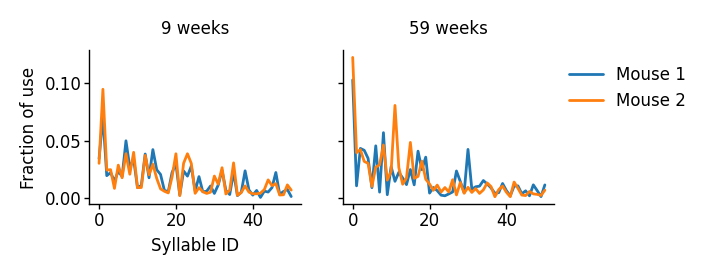

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(3, 1), sharey=True)
ax[0].plot(b1, label="Mouse 1")
ax[0].plot(b2, label="Mouse 2")
ax[1].plot(b3, label="Mouse 1")
ax[1].plot(b4, label="Mouse 2")
ax[1].set(title="59 weeks")
ax[0].set(xlabel="Syllable ID", ylabel="Fraction of use", title="9 weeks")
legend(ax[1])
sns.despine()
saver(fig, "usage-examples-two-mice");

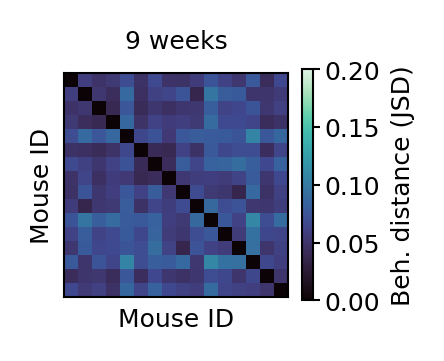

In [21]:
age = syll_df['age'].min()
out = squareform(pdist(ba.loc[ind1]))
fig = figure(1.2, 1)
ax = fig.gca()
im = ax.imshow(out, vmax=0.2, cmap='mako')
ax.set(xticks=[], yticks=[], xlabel="Mouse ID", ylabel="Mouse ID", title=f"{age} weeks")
fig.colorbar(im, ax=ax, label="Beh. distance (JSD)")
saver(fig, f"{age}wk-old-beh-distance-mtx");

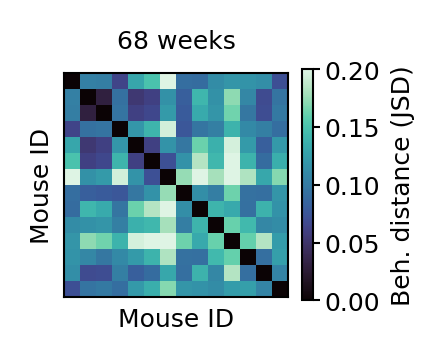

In [22]:
age = syll_df['age'].max()
out = squareform(pdist(ba.loc[ind2]))
fig = figure(1.2, 1)
ax = fig.gca()
im = ax.imshow(out, vmax=0.2, cmap='mako')
ax.set(xticks=[], yticks=[], xlabel="Mouse ID", ylabel="Mouse ID", title=f"{age} weeks")
fig.colorbar(im, ax=ax, label="Beh. distance (JSD)")
saver(fig, f"{age}wk-old-beh-distance-mtx");